<a href="https://colab.research.google.com/github/cmannnn/predict_future_sales/blob/main/predict_future_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# File descriptions

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


itemcats_df - supplemental information about the items categories.

items_df - supplemental information about the items/products.

salestrain_df - the training set. Daily historical data from January 2013 to October 2015.

shops_df - supplemental information about the shops.

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.

# Imports and uploads

In [3]:
# imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import datetime as dt

#import specific sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline

from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

from sklearn import linear_model

In [4]:
#!pip install kaggle

In [5]:
# UPLOAD YOUR kaggle.json KEY HERE

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [6]:
print('This if for the Jupyter Fam')

This if for the Jupyter Fam


In [7]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         96           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        205           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        470           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       3221           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      25877            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       6521           False  
connectx

In [8]:
!mkdir -p predict_future_sales

In [9]:
# UPLOAD 6 FILES HERE
uploaded2 = files.upload()

Saving item_categories.csv to item_categories.csv
Saving items.csv to items.csv
Saving sample_submission.csv to sample_submission.csv
Saving sales_train.csv to sales_train.csv
Saving shops.csv to shops.csv
Saving test.csv to test.csv


In [10]:
!cp test.csv predict_future_sales/
!cp item_categories.csv predict_future_sales/
!cp items.csv predict_future_sales/
!cp sales_train.csv predict_future_sales/
!cp sample_submission.csv predict_future_sales/
!cp shops.csv predict_future_sales/
!cp test.csv predict_future_sales/

# Importing All Predict Sales Data

In [11]:
#importing all the data frames
itemcats_df = pd.read_csv("predict_future_sales/item_categories.csv") #Item Categories
items_df = pd.read_csv("predict_future_sales/items.csv", encoding='unicode_escape') # Items
salestrain_df = pd.read_csv("predict_future_sales/sales_train.csv") #Sales Data - Training
shops_df = pd.read_csv("predict_future_sales/shops.csv", encoding='unicode_escape') # Shops

In [12]:
# sample submission dataframe
sample_df = pd.read_csv('predict_future_sales/sample_submission.csv')

# test data frame
test_df = pd.read_csv('predict_future_sales/test.csv')

# Data EDA

In [13]:
# creating a master list of all dataframes
df_list = [itemcats_df, items_df, salestrain_df, shops_df]

In [14]:
# creating a loop to print head, description, info, and null sum for each datafram in master list 
for df in df_list:
    print(f'DATAFRAME HEAD: {df.head()}')
    print('-----------------------')
    print(f'DATAFRAME DESCRIPTION: {df.describe()}')
    print('-----------------------')
    print(f'DATAFAME INFO: {df.info()}')
    print('-----------------------')
    print(f'DATAFRAME NULL SUM: {df.isnull().sum()}')
    print('------------------------------------------------------------------------------')

DATAFRAME HEAD:            item_category_name  item_category_id
0  PC - Headsets / Headphones                 0
1           Accessories - PS2                 1
2           Accessories - PS3                 2
3           Accessories - PS4                 3
4           Accessories - PSP                 4
-----------------------
DATAFRAME DESCRIPTION:        item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
DATAFAME INFO: None
-----------------------
DATAFRAME NULL SUM: i

In [15]:
# checking itemcats_df column data types
itemcats_df.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [16]:
# checking item_df column data types
items_df.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [17]:
# checking salestrain_df data types
salestrain_df.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [18]:
# changing salestrain 'item_cnt_day' col from float64 -> int16
salestrain_df['item_cnt_day'] = pd.to_numeric(salestrain_df['item_cnt_day'], downcast='signed')

In [19]:
# changing salestrain 'date' col from object -> datetime
salestrain_df['date'] = pd.to_datetime(salestrain_df['date'])

In [20]:
shops_df.dtypes

shop_name    object
shop_id       int64
dtype: object

# Combine DFs

In [21]:
# combining training dataframes into master training set
salestrain_df_combined = salestrain_df.merge(items_df,on='item_id')
salestrain_df_combined = salestrain_df_combined.merge(itemcats_df,on='item_category_id')
salestrain_df_combined = salestrain_df_combined.merge(shops_df,on='shop_id')

In [22]:
salestrain_df_combined.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

In [23]:
# setting the id col, and 2 target cols based on testing data
id_col, target_col_item, target_col_shop = salestrain_df.index, salestrain_df_combined['item_id'], salestrain_df_combined['shop_id']

# Data Viz

In [24]:
# adding features for separating date
salestrain_df_combined['year'] = salestrain_df_combined.date.dt.year
salestrain_df_combined['month'] = salestrain_df_combined.date.dt.month
salestrain_df_combined['day'] = salestrain_df_combined.date.dt.day

# adding revenue feature
salestrain_df_combined['revenue'] = salestrain_df_combined.item_price * salestrain_df_combined.item_cnt_day
salestrain_df_combined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
0,2013-02-01,0,59,22154,999.0,1,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0
1,2013-04-26,3,59,944,150.0,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,4,26,150.0
2,2013-06-26,5,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,26,199.5
3,2013-07-20,6,59,944,199.5,1,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,7,20,199.5
4,2013-09-14,8,59,944,299.0,2,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,9,14,598.0


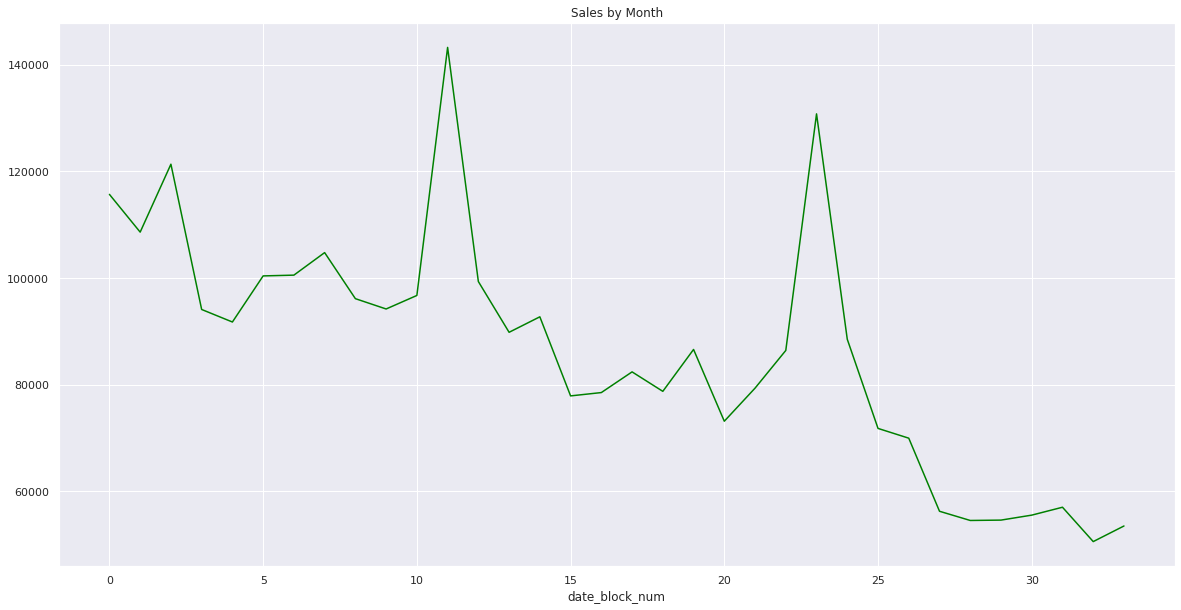

In [25]:
sns.set()
salestrain_df_combined.groupby('date_block_num').date.count().plot.line(title='Sales by Month', color='green', figsize=(20, 10))

As we can see, sales are decreasing through the years. 
We also see a spike sale during december. 
Since, the dataset is up to October, are we seeing some spike in year 2015?

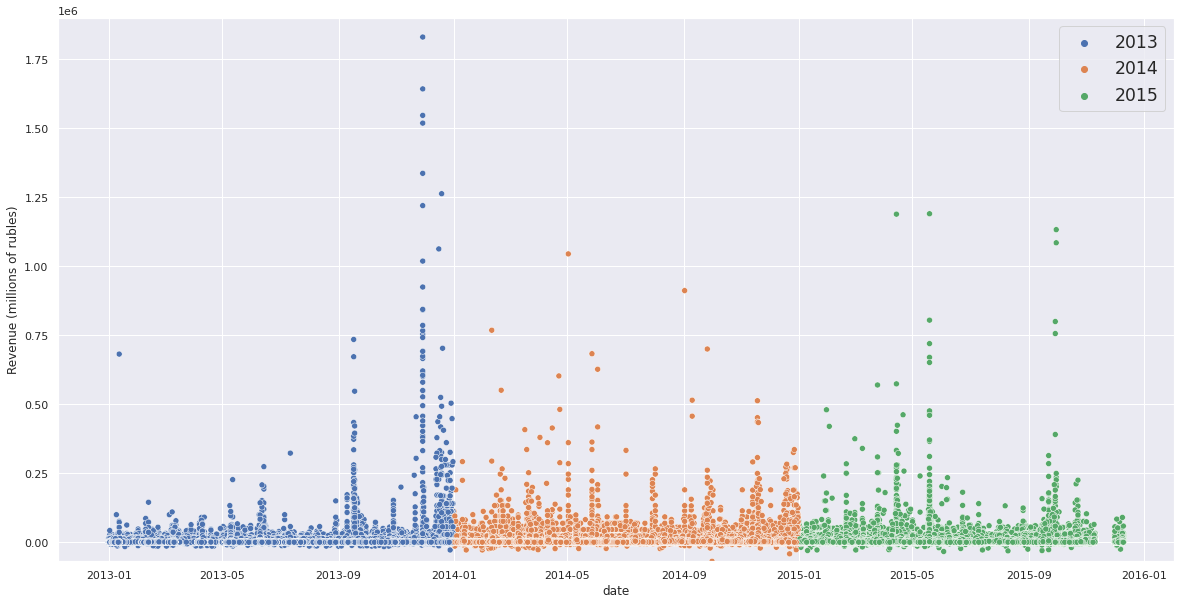

In [26]:
# time series scatterplot of revenue highlighting years
plt.figure(figsize = (20, 10))
sns.scatterplot(x = salestrain_df_combined['date'], y = salestrain_df_combined['revenue'], hue = salestrain_df_combined['year'], palette='deep')
plt.ylim(salestrain_df_combined['revenue'].min(), 1900000)
#plt.arrow(2013-11-29, 1829990.0000013, 2013-11-30, 1700000, head_width = 10, head_length = 11)
#plt.axvline()
plt.ylabel('Revenue (millions of rubles)')
plt.legend(fontsize='x-large')
plt.show()

In [27]:
# printing most amount of revenue and least amount of revenue
print(f'The least amount of revenue recorded is: {salestrain_df_combined.revenue.min()}')
print(f'The most amount of revenue recorded is: {salestrain_df_combined.revenue.max()}')

The least amount of revenue recorded is: -68970.0
The most amount of revenue recorded is: 1829990.0000013


In [28]:
# day with the highest amount of revenue
print('The date with the most amount of revenue is:', salestrain_df_combined.loc[salestrain_df_combined['revenue'] == 734571.99999936, 'date'].values[0])

The date with the most amount of revenue is: 2013-09-17T00:00:00.000000000


In [29]:
# masking revenue numbers to show negative revenue
# not sure how to have negative revenue
# item returns?
salestrain_neg_mask = salestrain_df_combined['revenue'] < 0
salestrain_df_combined[salestrain_neg_mask].head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
181,2013-02-25,1,59,10308,399.00,-1,GANGSTER (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,25,-399.00
204,2013-06-20,5,59,14549,149.00,-1,The meeting place can not be changed e (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,20,-149.00
1894,2014-12-09,20,59,19089,149.00,-1,Star Trek RETRIBUTION (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,12,9,-149.00
2056,2014-05-20,16,59,11034,425.76,-1,JFK: SHOTS in Dallas (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,5,20,-425.76
2082,2013-11-18,10,59,19688,999.00,-1,Pacific Rim (2 BD) + 3D card,37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,11,18,-999.00
2472,2014-11-26,22,59,14598,499.00,-1,Million Ways HEAD (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2014,11,26,-499.00
2768,2013-06-28,5,59,5500,1449.00,-1,PINK FLOYD The Wall Original Recording Remaste...,56,Music - CD production firm,"Yaroslavl shopping center ""Altair""",2013,6,28,-1449.00
2993,2013-10-22,9,59,1729,299.00,-1,BOCELLI ANDREA Amore,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2013,10,22,-299.00
3331,2014-02-05,16,59,7299,399.00,-1,V / A Classical Beatles 2CD,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2014,2,5,-399.00
4157,2013-12-31,11,59,21565,349.00,-1,CHOI Victor Tsoi 50,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2013,12,31,-349.00


In [30]:
# grouping revenue by month and rounding number
monthly_group = salestrain_df_combined.groupby(by=['month'])
monthly_group_sum = monthly_group['revenue'].sum().round()      
monthly_group_sum                   

month
1     248888930.0
2     283474409.0
3     297738796.0
4     260400096.0
5     281549528.0
6     246674065.0
7     228964549.0
8     250892203.0
9     318244583.0
10    253804098.0
11    296913609.0
12    431381479.0
Name: revenue, dtype: float64

In [31]:
# normalizing data for visualization
monthly_group_norm = (monthly_group_sum - monthly_group_sum.mean()) / (monthly_group_sum.max() - monthly_group_sum.min())
monthly_group_norm = abs(monthly_group_norm)
monthly_group_norm

month
1     0.169724
2     0.001139
3     0.071609
4     0.112855
5     0.008371
6     0.180666
7     0.268156
8     0.159827
9     0.172914
10    0.145441
11    0.067533
12    0.731844
Name: revenue, dtype: float64

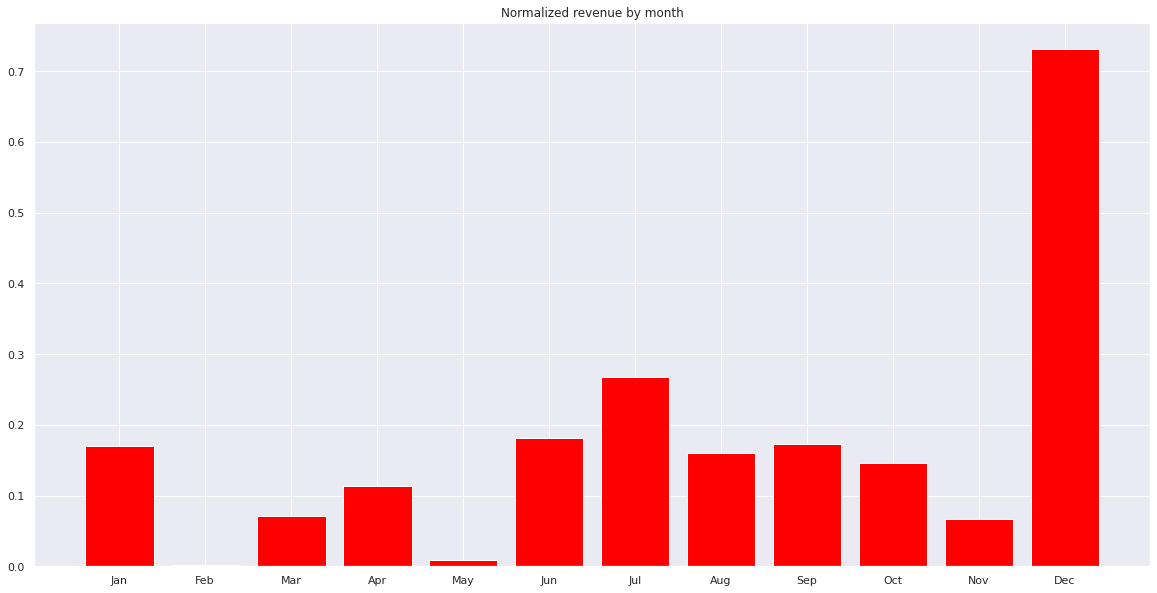

In [32]:
# graphing normalized revenue
# look at those december sales!!
ax, fig = plt.subplots(figsize=(20,10))
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(cols, monthly_group_norm, color='red')
plt.title('Normalized revenue by month')
plt.show()

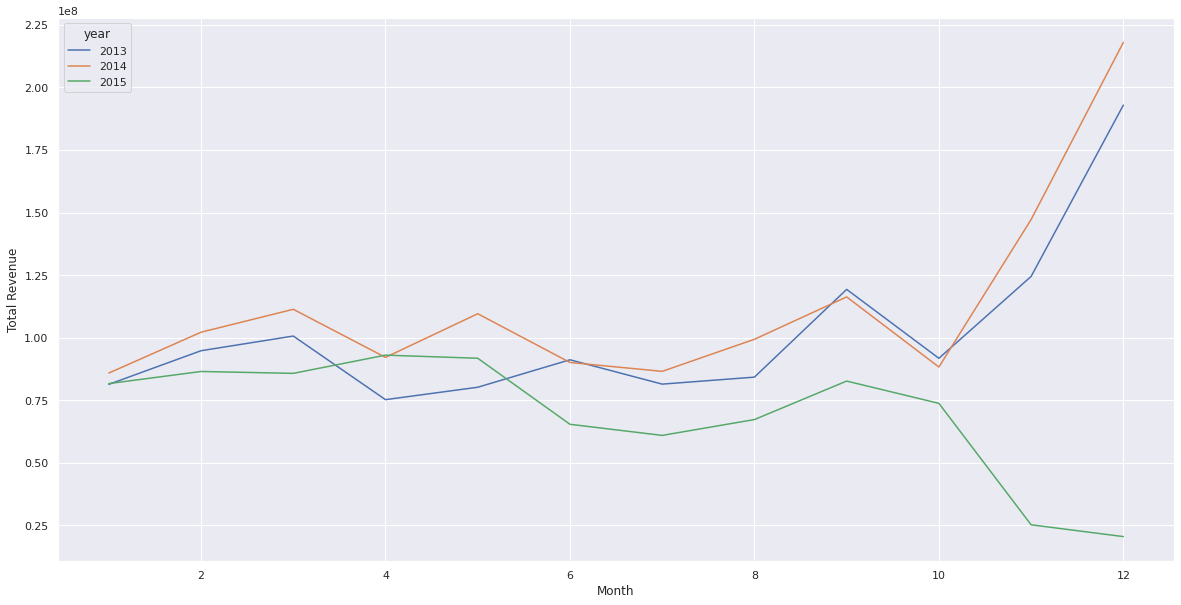

In [33]:
# Plot total revenue by month for each year
salestrain_df_combined.groupby(['month', 'year']).sum()['revenue'].unstack().plot(figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

There are no sales spike on december 2015.

In [34]:
# creating list of top selling items
top_items = [20949, 5822, 17717, 2808, 4181, 7856, 3732, 2308, 4870, 3734]

# creating empty list to append to
top_item_cols = []

# loop to append item name based on top selling items
for items in top_items:
  top_item_cols.append(salestrain_df_combined.loc[salestrain_df_combined['item_id'] == items, 'item_name'].values[0])

top_item_cols

['Corporate package white shirt 1C Interest (34 * 42) 45 m',
 'Playstation Store replenishment wallet: Map payment of 1000 rubles.',
 'Receiving cash for 1C-line',
 'Diablo III [PC, Jewel, Russian version]',
 'Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box',
 'World of Warcraft. possession of payment card (online) (rus.v.) (60 days) (Jewel)',
 'Grand Theft Auto V [PS3, Russian subtitles]',
 'Call of Duty: Black Ops II [Pc, Jewel, Russian version]',
 'Minecraft [Xbox 360, English version]',
 'Grand Theft Auto V [Xbox 360, Russian subtitles]']

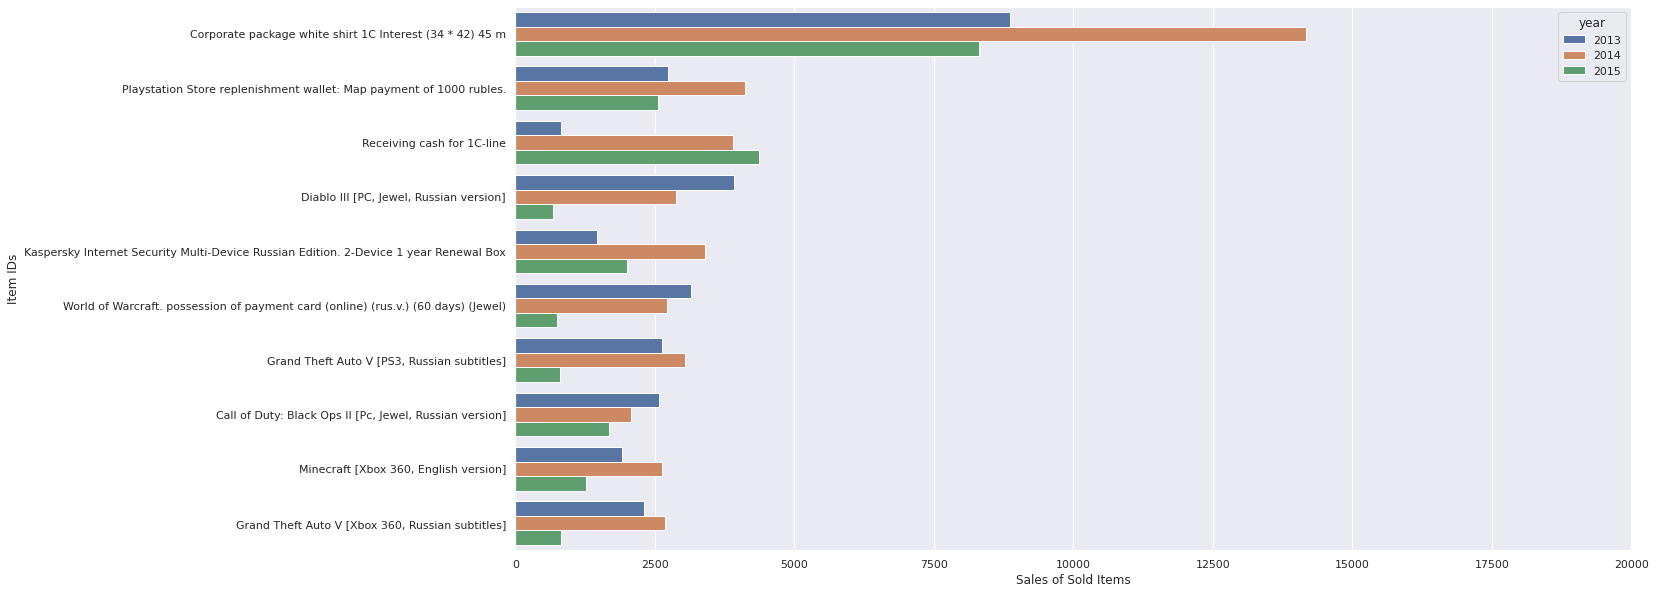

In [35]:
# Plot the top 10 most items sold
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(y = 'item_id', hue = 'year', data = salestrain_df_combined, order = salestrain_df_combined['item_id'].value_counts().iloc[:10].index)
ax.set_yticklabels(top_item_cols)
plt.xlim(0, 20000)
plt.xlabel('Sales of Sold Items')
plt.ylabel('Item IDs')
plt.show()

In [36]:
salestrain_df_combined['item_id'] == 20949

0          False
1          False
2          False
3          False
4          False
           ...  
2935844    False
2935845    False
2935846    False
2935847    False
2935848    False
Name: item_id, Length: 2935849, dtype: bool

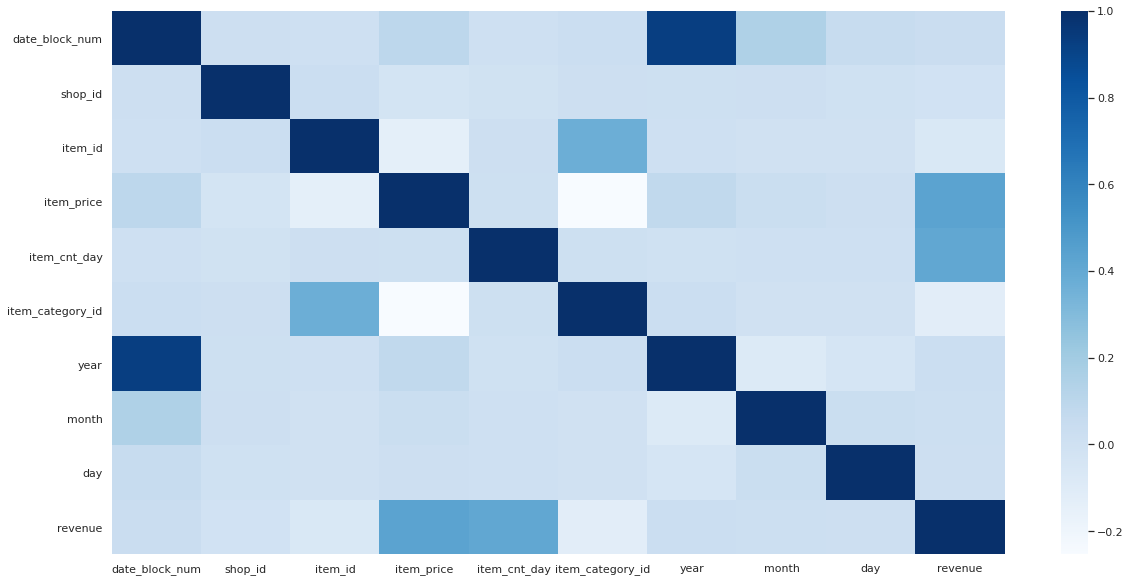

In [37]:
plt.figure(figsize = (20, 10))
sns.heatmap(salestrain_df_combined.corr(), cmap='Blues')
plt.show()

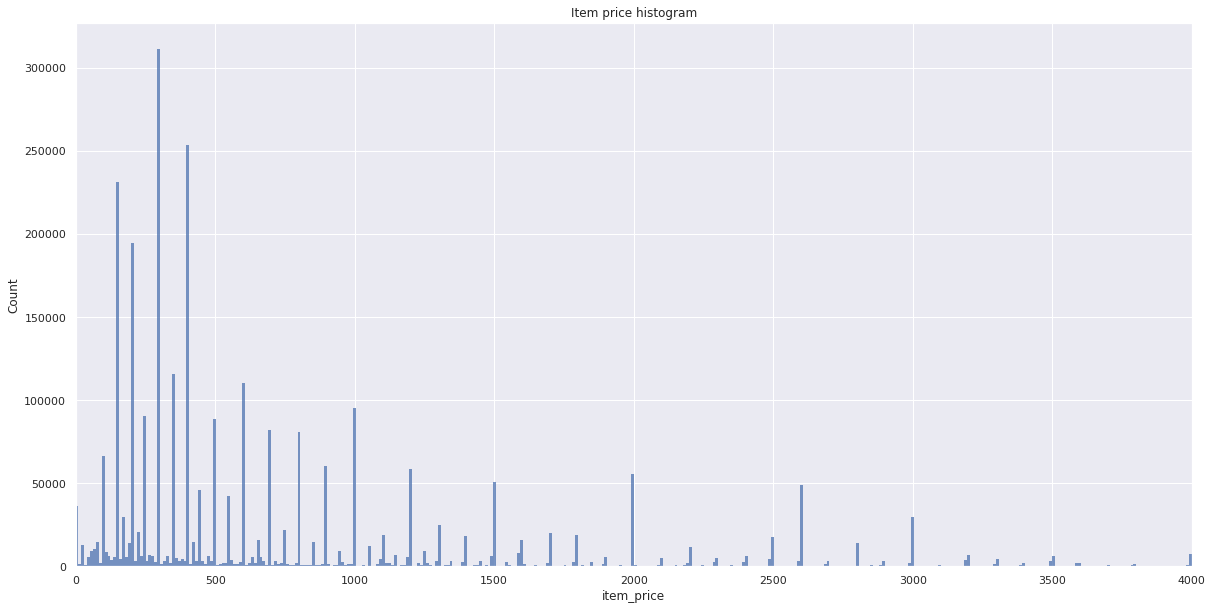

In [38]:
# plotting histogram of the price of items
# some high ticket items, lots 
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='item_price', data=salestrain_df)
plt.xlim(0, 4000)
plt.title('Item price histogram')
plt.show()

create item price bands to graph

whisker plot with yearly revenue?

pair plot variation? diag_kind='hist'

sns.scatterplot

# Feature selection

Make features for MA: 7, 30, 60, 90 days, season, month

Convert into categorical - Store, Item

In [39]:
# item names with their revenue and sold count
item_names = salestrain_df_combined.groupby('item_name').agg({'revenue':'sum', 'item_cnt_day':'count'}).reset_index().rename(columns={'item_name': 'Item Name', 'revenue': 'Revenue', 'item_cnt_day': 'Number of Sales'})
item_names.head()

,Item Name,Revenue,Number of Sales
0,! ABBYY FineReader 12 Professional Edition Ful...,26940.00,6
1,! POWER IN glamor (PLAST.) D,58.00,1
2,"""Grand BUDAPEST"" (BD)",295962.82,552
3,"""Grand Budapest""",403935.42,911
4,"""Operation Bagration» [PC, Digital Version]",9765.00,31


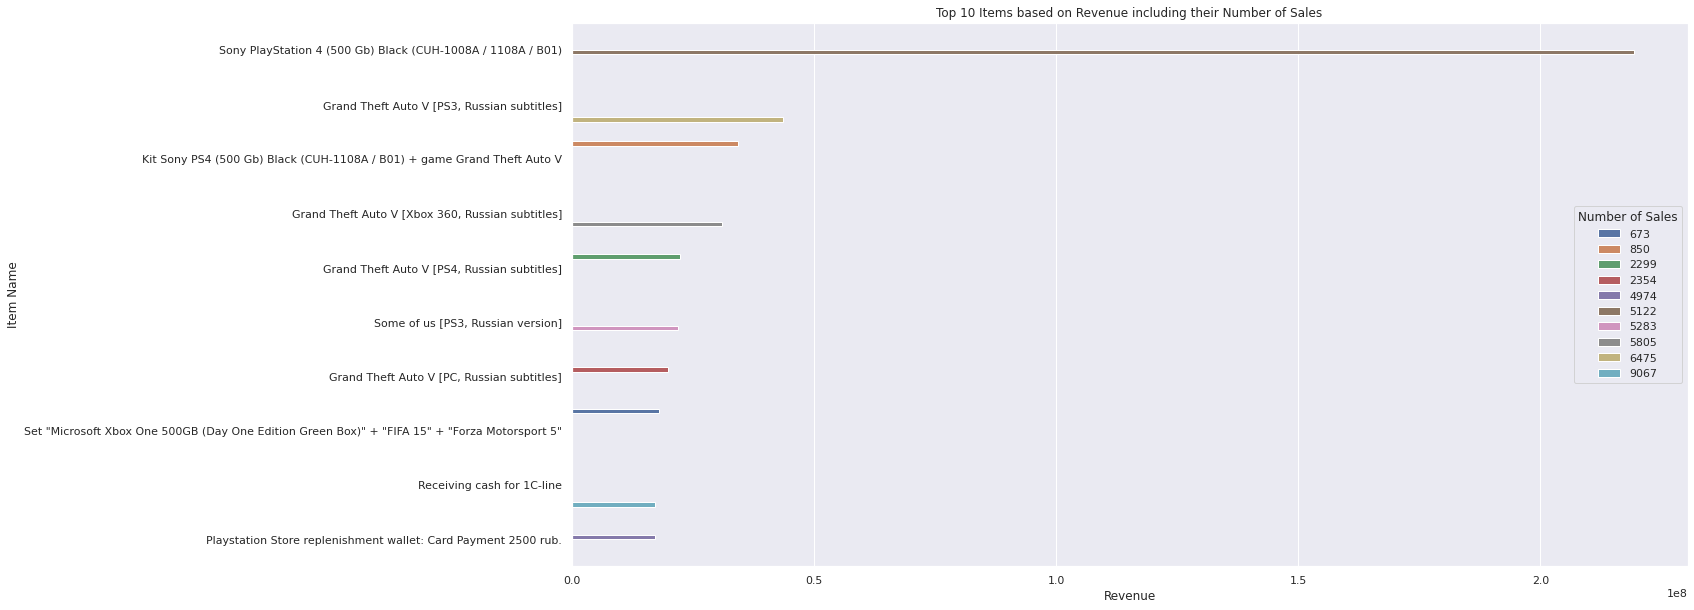

In [40]:
# top 10 items based on their revenue
top10_revenue = item_names.nlargest(10, 'Revenue')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_revenue, hue='Number of Sales', x='Revenue', y='Item Name')
plt.title("Top 10 Items based on Revenue including their Number of Sales")
plt.show()

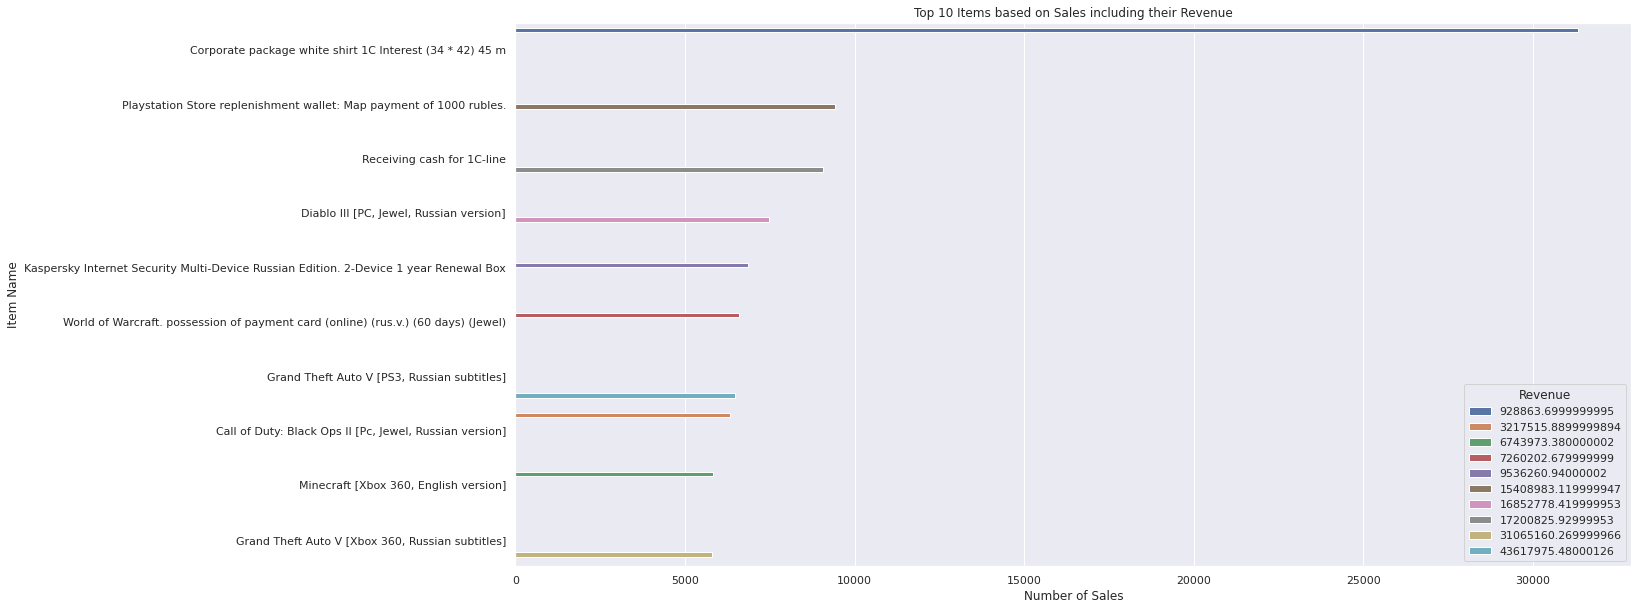

In [41]:
# top 10 items based on their revenue
top10_sales = item_names.nlargest(10, 'Number of Sales')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_sales, x='Number of Sales', y='Item Name', hue='Revenue')
plt.title("Top 10 Items based on Sales including their Revenue")
plt.show()

In [42]:
# category names and how many items in it.
category_names = salestrain_df_combined.groupby(['item_category_name']).agg({'item_name':'count'}).reset_index().rename(columns={'item_category_name': 'Category Name','item_name': 'Number of Items'})
category_names.head()

,Category Name,Number of Items
0,Accessories - PS2,2
1,Accessories - PS3,18461
2,Accessories - PS4,25283
3,Accessories - PSP,2304
4,Accessories - PSVita,7231


In [43]:
#Find total sales by item
total_sales_by_item = salestrain_df_combined.groupby('item_id')['item_cnt_day'].sum().reset_index()

#Sort descending
total_sales_by_item.sort_values(by='item_cnt_day',ascending=False,inplace=True)
total_sales_by_item.head()

,item_id,item_cnt_day
20602,20949,187642.0
2749,2808,17245.0
3654,3732,16642.0
17418,17717,15830.0
5717,5822,14515.0


In [44]:
#Merge together so we can get item_name with total sales values
total_sales_by_item_with_name = total_sales_by_item.merge(items_df[['item_name','item_id']],on='item_id')
total_sales_by_item_with_name.head()

,item_id,item_cnt_day,item_name
0,20949,187642.0,Corporate package white shirt 1C Interest (34 ...
1,2808,17245.0,"Diablo III [PC, Jewel, Russian version]"
2,3732,16642.0,"Grand Theft Auto V [PS3, Russian subtitles]"
3,17717,15830.0,Receiving cash for 1C-line
4,5822,14515.0,Playstation Store replenishment wallet: Map pa...


In [45]:
total_sales_by_item['item_cnt_day'].iloc[:10]

20602    187642.0
2749      17245.0
3654      16642.0
17418     15830.0
5717      14515.0
3656      11688.0
6543      10289.0
3653      10099.0
1814      10032.0
16493      9227.0
Name: item_cnt_day, dtype: float64

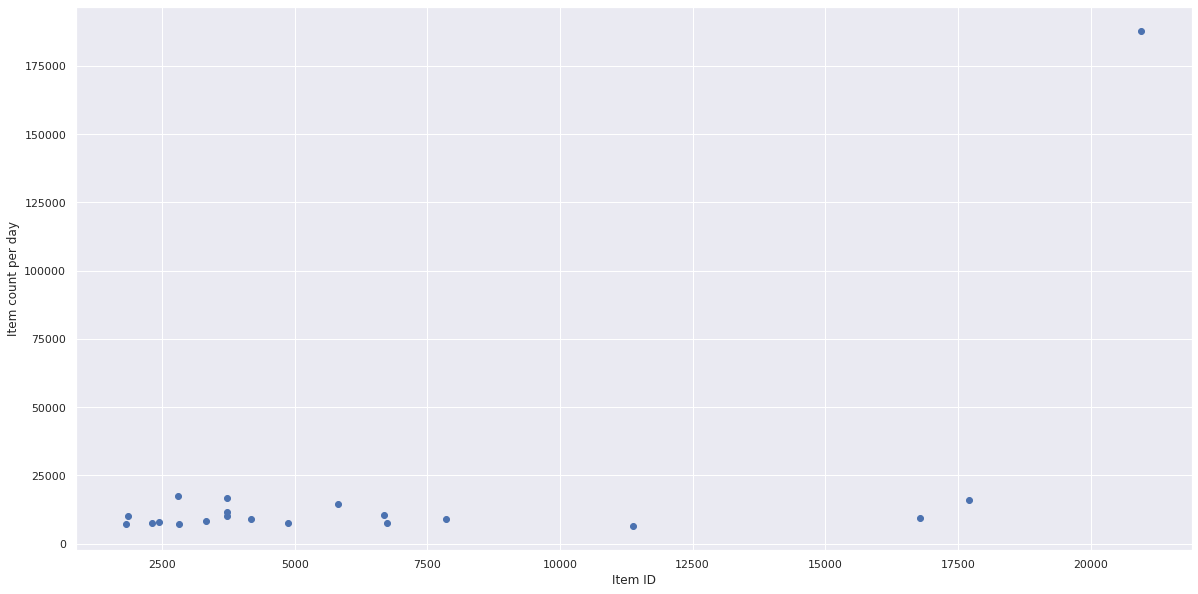

In [46]:
# updated scatterplot showing top 20 best selling items day to day
fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(y = total_sales_by_item['item_cnt_day'].iloc[:20], x = total_sales_by_item['item_id'].iloc[:20])
plt.xlabel('Item ID')
plt.ylabel('Item count per day')
plt.show()

##Recommendation Engine

In [47]:
# Get sales by item, by date - again, not very exciting,so I also used fillna()
sales_totals_by_day = salestrain_df_combined.pivot_table(index='item_id',columns=['year', 'month', 'day'],values='item_cnt_day').fillna(0)

In [48]:
# Clean up the multi-level index
sales_totals_by_day.columns = sales_totals_by_day.columns.droplevel().droplevel()

In [49]:
sales_totals_by_day.head()

day,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,1,2,3,4,5,6,7,8,9,...,10,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Shape of the resulting DF - items x days
sales_totals_by_day.shape

(21807, 1034)

In [51]:
#Transpose this
sales_totals_by_day_transposed = sales_totals_by_day.transpose()

In [52]:
sales_totals_by_day_transposed.head()

item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,22129,22130,22131,22132,22133,22134,22135,22136,22138,22139,22140,22141,22142,22143,22144,22145,22146,22147,22148,22149,22150,22151,22152,22153,22154,22155,22156,22157,22158,22159,22160,22161,22162,22163,22164,22165,22166,22167,22168,22169
day,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.166667,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.600000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.333333,1.0,1.0,1.428571,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.214286,1.1,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,1.0,1.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.0,1.000000,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Recommendation engine - find the closest matches to an item in terms of daily sales
# Similar to finding similar movies based on movie rating

#Select a popular item
selected_item = 2808

In [54]:
#Pull out the column of that day's sales
selected_item_sales = sales_totals_by_day_transposed[selected_item]

In [55]:
#Run correlation with every other column to find similar sales patterns
similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)

In [56]:
#Convert from a series to a DF
similarItems_df = pd.DataFrame(similarItems)

In [57]:
similarItems_df.head()

,0
item_id,
0,-0.005647
1,-0.019637
2,-0.011574
3,-0.005914
4,-0.008847


In [58]:
#Rename columns
similarItems_df.columns=['similarity']

In [59]:
similarItems_df.head()

,similarity
item_id,
0,-0.005647
1,-0.019637
2,-0.011574
3,-0.005914
4,-0.008847


In [60]:
#Merge back item names
similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')

In [61]:
#Sort
similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)

In [62]:
#The top results for item 2808 seem to make some sense (games), but they also include programming books and other things-inconclusive?
similarItems_df_sorted.head(20)

,similarity,item_name,item_id
2808,1.000000,"Diablo III [PC, Jewel, Russian version]",2808
10956,0.489434,Django Unchained,10956
19149,0.477112,Stukachev (Paradis),19149
7100,0.445205,"Total War: Rome II (Pre-Order) [PC, Digital Ve...",7100
12571,0.423180,Fight fire,12571
13809,0.420981,LEGEND ? 17 (BD + DVD) + BD bouncer,13809
1476,0.416799,"Assassin's Creed 3. Washington [PC, Russian ve...",1476
16900,0.414021,PARKER,16900
19529,0.411316,Timeless. RUBY BOOK,19529
14429,0.403746,MASHA AND THE BEAR. GROWTH VITAMIN,14429


In [63]:
#Function to return the values:

def find_similar_based_on_daily_sales(selected_item,sales_totals_by_day_transposed=sales_totals_by_day_transposed):
    selected_item_sales=sales_totals_by_day_transposed[selected_item]
    similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)
    similarItems_df=pd.DataFrame(similarItems)
    similarItems_df.columns=['similarity']
    similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')
    similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)
    print(similarItems_df_sorted.head(20))

In [64]:
find_similar_based_on_daily_sales(2808)

       similarity                                          item_name  item_id
2808     1.000000            Diablo III [PC, Jewel, Russian version]     2808
10956    0.489434                                   Django Unchained    10956
19149    0.477112                                Stukachev (Paradis)    19149
7100     0.445205  Total War: Rome II (Pre-Order) [PC, Digital Ve...     7100
12571    0.423180                                         Fight fire    12571
13809    0.420981                LEGEND ? 17 (BD + DVD) + BD bouncer    13809
1476     0.416799  Assassin's Creed 3. Washington [PC, Russian ve...     1476
16900    0.414021                                             PARKER    16900
19529    0.411316                                Timeless. RUBY BOOK    19529
14429    0.403746                 MASHA AND THE BEAR. GROWTH VITAMIN    14429
16736    0.400455                                     Gangster Squad    16736
7250     0.393255  V / A A State Of Trance The Expidition Episod

In [65]:
#What is similar to those corporate T-shirts?
find_similar_based_on_daily_sales(20949)

       similarity                                          item_name  item_id
20949    1.000000  Corporate package white shirt 1C Interest (34 ...    20949
4870     0.495240              Minecraft [Xbox 360, English version]     4870
6498     0.468782  Sims 3: Island Paradise (addition) [PC, Russia...     6498
972      0.453684        30 SECONDS TO MARS Love Lust Faith + Dreams      972
16169    0.450443  Board game Mafia whole family assembly (card g...    16169
21377    0.449419         The Hobbit: An Unexpected Journey (region)    21377
15063    0.449285  Might and Magic. Heroes 6. The Edge of Darknes...    15063
3183     0.420425  Elder Scrolls V: Skyrim Legendary Edition [PC,...     3183
20947    0.401237  Phineas and Ferb. Conquest of the second measu...    20947
8686     0.395513                                            BASTA 4     8686
4181     0.388508  Kaspersky Internet Security Multi-Device Russi...     4181
6084     0.384239              Rayman Legends [PS3, Russian vers

In [66]:
#What is similar to minecraft?
find_similar_based_on_daily_sales(4870)

       similarity                                          item_name  item_id
4870     1.000000              Minecraft [Xbox 360, English version]     4870
4181     0.698090  Kaspersky Internet Security Multi-Device Russi...     4181
4178     0.658616  Kaspersky Internet Security Multi-Device Russi...     4178
3423     0.564589   Far Cry 3 (Classics) [Xbox 360, Russian version]     3423
21377    0.544731         The Hobbit: An Unexpected Journey (region)    21377
10659    0.541108  Puzzle Rubik's Cube 3x3 without labels, soft m...    10659
6498     0.525330  Sims 3: Island Paradise (addition) [PC, Russia...     6498
4904     0.515135  Mortal Kombat. Komplete Edition [PC, Jewel, Ru...     4904
10292    0.512199                                      DESPICABLE ME    10292
3183     0.509814  Elder Scrolls V: Skyrim Legendary Edition [PC,...     3183
20949    0.495240  Corporate package white shirt 1C Interest (34 ...    20949
6497     0.486503    Sims 3: Set for beginners [PC, Russian vers

In [67]:
#This item averaged 5 sales per day, max of 35, so it wasn't distorted by one overwhelmingly high corporate order
sales_totals_by_day_transposed[20949].describe()

count    1034.000000
mean        5.099070
std         3.283973
min         0.000000
25%         3.670000
50%         4.697505
75%         6.368421
max        35.531250
Name: 20949, dtype: float64

## Rolling window K-fold cross-validation

In [68]:
salestrain_df_combined.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'year', 'month', 'day', 'revenue'],
      dtype='object')

In [69]:
# setting X as date col and y as revenue col to be split
X = salestrain_df_combined['date']
y = salestrain_df_combined['revenue']

In [70]:
# creating the time series split, one split for every month in the year
tscv = TimeSeriesSplit(n_splits = 12)

In [71]:
# looping through every time series split 
for train_index, test_index in tscv.split(X):
  print(f'TRAIN SHAPE: {train_index.shape} TEST SHAPE: {test_index.shape}')
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[train_index]

TRAIN SHAPE: (225841,) TEST SHAPE: (225834,)
TRAIN SHAPE: (451675,) TEST SHAPE: (225834,)
TRAIN SHAPE: (677509,) TEST SHAPE: (225834,)
TRAIN SHAPE: (903343,) TEST SHAPE: (225834,)
TRAIN SHAPE: (1129177,) TEST SHAPE: (225834,)
TRAIN SHAPE: (1355011,) TEST SHAPE: (225834,)
TRAIN SHAPE: (1580845,) TEST SHAPE: (225834,)
TRAIN SHAPE: (1806679,) TEST SHAPE: (225834,)
TRAIN SHAPE: (2032513,) TEST SHAPE: (225834,)
TRAIN SHAPE: (2258347,) TEST SHAPE: (225834,)
TRAIN SHAPE: (2484181,) TEST SHAPE: (225834,)
TRAIN SHAPE: (2710015,) TEST SHAPE: (225834,)


## Removing features with low variance

In [72]:
salestrain_df_combined.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'year', 'month', 'day', 'revenue'],
      dtype='object')

In [73]:
train_set = salestrain_df_combined.drop(columns = ['revenue'])

In [74]:
# mapping date col to ordinal for use with VarianceThreshold
train_set['date'] = train_set['date'].map(dt.datetime.toordinal)

In [75]:
for col in ['item_name', 'item_category_name', 'shop_name']:
   train_set[col] = LabelEncoder().fit_transform(train_set[col])

In [76]:
test_set = salestrain_df_combined['revenue']

In [77]:
train_set.dtypes

date                    int64
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day            int16
item_name               int64
item_category_id        int64
item_category_name      int64
shop_name               int64
year                    int64
month                   int64
day                     int64
dtype: object

In [78]:
test_set.shape

(2935849,)

In [79]:
# creating the Variance Threshold and setting variance to 10 -> can mess around with this number
threshold = VarianceThreshold(threshold = 10)

In [80]:
# fit transforming variance threshold to train set
high_variance = threshold.fit(train_set)

In [81]:
# seeing which cols do not have high variance
train_set.columns[high_variance.get_support()]

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_name', 'item_category_id', 'item_category_name', 'shop_name',
       'month', 'day'],
      dtype='object')

In [82]:
# seeing which cols have low variance
constant_cols = [column for column in train_set.columns if column not in train_set.columns[high_variance.get_support()]]
print(f'The columns with low(ish) variance is: {constant_cols}')

The columns with low(ish) variance is: ['item_cnt_day', 'year']


All of our features have high variance, therefore they don't have to be removed.

## K-Means clustering

In [83]:
#salestrain_df.head()
salestrain_df = salestrain_df.drop('date', axis=1)

In [84]:
salestrain_df.head(10)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,59,22154,999.00,1
1,0,25,2552,899.00,1
2,0,25,2552,899.00,-1
3,0,25,2554,1709.05,1
4,0,25,2555,1099.00,1
5,0,25,2564,349.00,1
6,0,25,2565,549.00,1
7,0,25,2572,239.00,1
8,0,25,2572,299.00,1
9,0,25,2573,299.00,3


In [85]:
# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, kmeans)

# Fit the pipeline to samples
pipeline.fit(np.array(salestrain_df))

# Calculate the cluster labels: labels
labels = pipeline.predict(salestrain_df)

# Create a DataFrame with labels and prices as columns: salestrain_df
#salestrain_df = pd.DataFrame({'item_price': item_price, 'item_cnt_day': item_cnt_day})

# Create crosstab: ct
ct = pd.crosstab(salestrain_df['item_price'], salestrain_df['item_cnt_day'])

# Display ct
print(ct.sort_values('item_price'))

item_cnt_day  -22    -16    -9     -6     ...   637    669    1000   2169
item_price                                ...                            
-1.0000           0      0      0      0  ...      0      0      0      0
 0.0700           0      0      0      0  ...      0      0      0      0
 0.0875           0      0      0      0  ...      0      0      0      0
 0.0900           0      0      0      0  ...      0      0      0      0
 0.1000           0      0      0      0  ...      0      0      0      0
...             ...    ...    ...    ...  ...    ...    ...    ...    ...
 42990.0000       0      0      0      0  ...      0      0      0      0
 49782.0000       0      0      0      0  ...      0      0      0      0
 50999.0000       0      0      0      0  ...      0      0      0      0
 59200.0000       0      0      0      0  ...      0      0      0      0
 307980.0000      0      0      0      0  ...      0      0      0      0

[19993 rows x 198 columns]


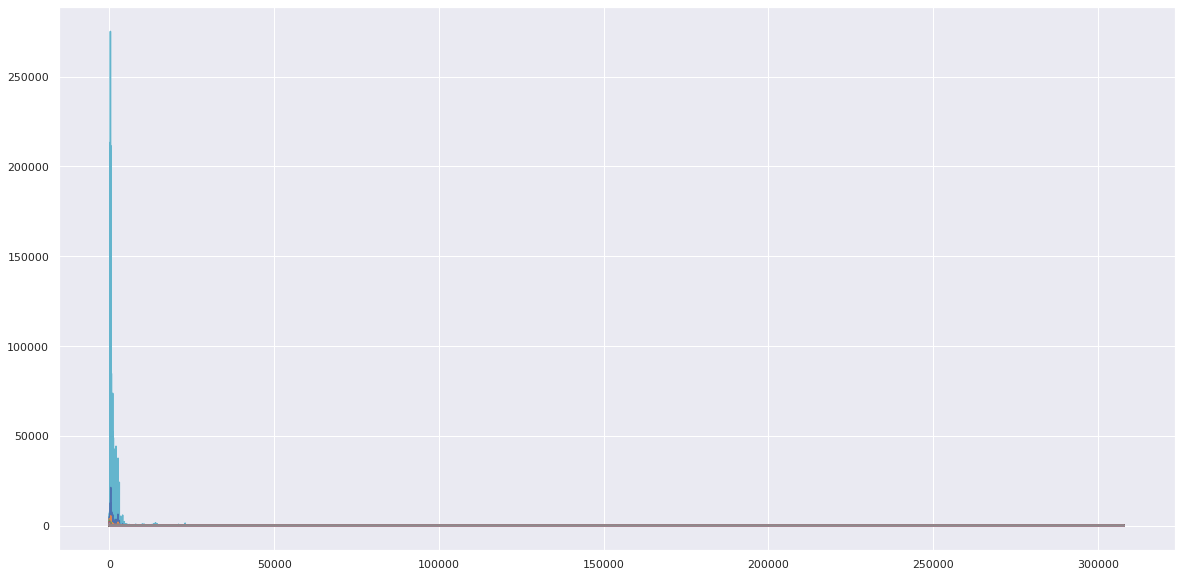

In [86]:
# plotting clusters
plt.figure(figsize=(20, 10))
plt.plot(ct)
plt.show()

In [87]:
# reshaping values to workable vector
dfx = salestrain_df.values.reshape(1, -1)
dfy = salestrain_df.values.reshape(1, -1)

In [88]:
# WHY DELETING?

# delete part 1
#dfx = np.delete(dfx, 0)
#dfy = np.delete(dfy, 0)

In [89]:
# WHY DELETING?

# delete part 2
#dfx = np.delete(dfx, 1)
#dfy = np.delete(dfy, 1)

In [90]:
print(f'dfx shape: {dfx.shape}')
print(f'dfy shape: {dfy.shape}')

dfx shape: (1, 14679245)
dfy shape: (1, 14679245)


In [91]:
# setting variables train test split
X = dfx
y = dfy

# running logistic regression baseline
logreg =  LogisticRegression()
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ValueError: ignored

In [ ]:
# checking train, test shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [ ]:
#
logreg.fit(X_train, y_train)
y_pred =logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## Categorical features OHE